## Chapter 8 Quantum Walk with pyQuil

#### Classical Walk

In [25]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import expm
%matplotlib inline
from pyquil import Program
from pyquil.gates import H, X, CPHASE00
from pyquil.api import WavefunctionSimulator
from pyquil.api import ForestConnection
from pyquil.api import QVMConnection

qvm = QVMConnection()
wfn_sim = WavefunctionSimulator()

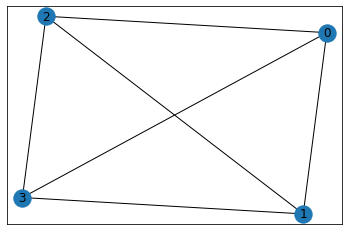

In [26]:
G = nx.complete_graph(4)
nx.draw_networkx(G)

In [27]:
A = nx.adjacency_matrix(G).toarray()
eigvals, _ = np.linalg.eigh(A)
print(eigvals)

[-1. -1. -1.  3.]


In [28]:
hamil = A + np.eye(4)

In [29]:
had = np.sqrt(1/2) * np.array([[1, 1], [1, -1]])
Q = np.kron(had, had)
Q.conj().T.dot(hamil).dot(Q)

array([[ 4.00000000e+00, -4.93038066e-32, -4.93038066e-32,
         4.93038066e-32],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

#### Continuous Time Quantum Walk (CTQW)

In [30]:
def k_4_ctqw(t):
    #   Change to diagonal basis
    p = Program(H(0), H(1), X(0), X(1))
    
    #    Time evolve
    p += CPHASE00(-4*t, 0, 1)
    
    #   Change back to computational basis
    p += Program(X(0), X(1), H(0), H(1))
    
    return p

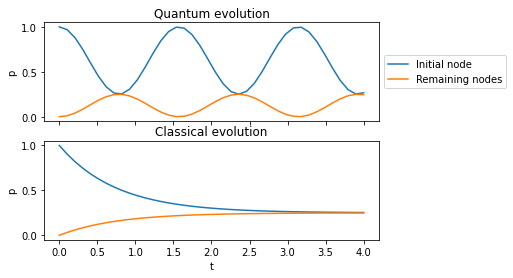

In [31]:
T = A / np.sum(A, axis=0)
time = np.linspace(0, 4, 40)
quantum_probs = np.zeros((len(time), 4))
classical_probs = np.zeros((len(time), 4))

for i, t in enumerate(time):
    p = k_4_ctqw(t)  
    wvf = wfn_sim.wavefunction(p)
    vec = wvf.amplitudes
    quantum_probs[i] = np.abs(vec)**2

    classical_ev = expm((T-np.eye(4))*t)
    classical_probs[i] = classical_ev[:, 0]    
    
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)

ax1.set_title("Quantum evolution")
ax1.set_ylabel('p')
ax1.plot(time, quantum_probs[:, 0], label='Initial node')
ax1.plot(time, quantum_probs[:, 1], label='Remaining nodes')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax2.set_title("Classical evolution")
ax2.set_xlabel('t')
ax2.set_ylabel('p')
ax2.plot(time, classical_probs[:, 0], label='Initial node')
ax2.plot(time, classical_probs[:, 1], label='Remaining nodes')

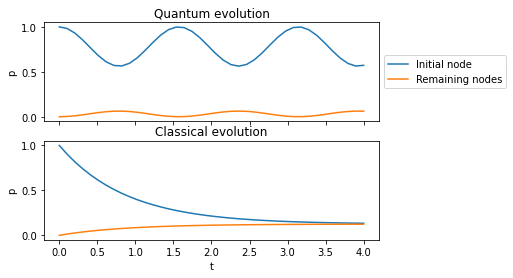

In [32]:
def k_2n_ctqw(n, t):
    p = Program()
    
    #    Change to diagonal basis
    for i in range(n):
        p += Program(H(i), X(i))

    #   Create and apply CPHASE00
    big_cphase00 = np.diag(np.ones(2**n)) + 0j
    big_cphase00[0, 0] = np.exp(-1j*4*t)
    p.defgate("BIG-CPHASE00", big_cphase00)     
    args = tuple(["BIG-CPHASE00"] + list(range(n)))
    p.inst(args)

    #   Change back to computational basis
    for i in range(n):
        p += Program(X(i), H(i))
    
    return p

def k_2n_crw(n, t):
    G = nx.complete_graph(2**n)
    A = nx.adjacency_matrix(G)
    T = A / A.sum(axis=0)
    classical_ev = expm((T-np.eye(2**n))*t)
    
    return classical_ev[:, 0]    

time = np.linspace(0, 4, 40)
quantum_probs = np.zeros((len(time), 8))
classical_probs = np.zeros((len(time), 8))

for i, t in enumerate(time):
    p = k_2n_ctqw(3, t)  
    wvf = wfn_sim.wavefunction(p)
    vec = wvf.amplitudes
    quantum_probs[i] = np.abs(vec)**2
    classical_probs[i] = k_2n_crw(3, t)  
    
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)

ax1.set_title("Quantum evolution")
ax1.set_ylabel('p')
ax1.plot(time, quantum_probs[:, 0], label='Initial node')
ax1.plot(time, quantum_probs[:, 1], label='Remaining nodes')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax2.set_title("Classical evolution")
ax2.set_xlabel('t')
ax2.set_ylabel('p')
ax2.plot(time, classical_probs[:, 0], label='Initial node')
ax2.plot(time, classical_probs[:, 1], label='Remaining nodes')